                                    Music Recommendation System

### Dataset: 
In this project, we are going to work with two datasets to implement Collaborative Filtering and Content-Based song recommendation system. 
Datasets: 

1- <b>MillionSongDataset (MSD):</b> 
We are working with a subset of this dataset(10k out of 350k)(http://millionsongdataset.com/pages/getting-dataset/)
It is possible to access the whole dataset by AWS, however it is not free. 
Although we are using the subset of this dataset, the code is <b><u>scalable</u></b>.
    
2- Implicit rating of 1million User(number of time a song played): http://millionsongdataset.com/tasteprofile/

#### Packages: 

In [14]:
import numpy as np
import pandas as pd
import tables   # Note: before installing pytables package, install HDF5, Numexpr, Cython, c-blosc packages
import h5py
import os
import fnmatch
import sys

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession, Row
from pyspark import SparkContext
from pyspark.sql.types import *

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark_dist_explore import hist # install by "pip install pyspark_dist_explore"

from pyspark.sql.functions import col,isnan,when,count

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer

import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.feature import RobustScaler, StandardScaler

import sklearn
from sklearn.metrics.pairwise import cosine_similarity

from pyspark.sql.functions import row_number, monotonically_increasing_id
from pyspark.sql import Window
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col, pow, psf

#### Create spark cluster: 

In [15]:
spark = SparkSession.builder.appName("Milion Songs Dataset").getOrCreate()
sc = SparkContext.getOrCreate()

#### path to datasets: 

In [16]:
data_MSD_path = 'MillionSongSubset'
data_imp_rating_path = 'train_triplets/train_triplets.txt'

### 1-First dataset: 
#### 1.1 Read the MSD dataset from HDF5 directories: 
- In order to read HDF5 file, HDFStore function of pandas library is used to read each .h5 file and keep in pyspark dataframe
- Each file(.h5) contains three keys <b>'/analysis/songs/', '/metadata/songs/', '/musicbrainz/songs/'
- Each key allow us to access data and metadata stored in the dataset 

#### Load the data in parallel with the help of spark RDD 

In [17]:
# load a sample of data to see the columns
hdf = pd.HDFStore(data_MSD_path+'/A/A/A/TRAAAAW128F429D538.h5',mode ='r', header = False)
df1 = hdf.get('/analysis/songs/')
df2 = hdf.get('/metadata/songs/')
df3 = hdf.get('/musicbrainz/songs/')
hdf.close()
sample_data_MSD = pd.concat([df1,df2,df3], axis = 1)
print(sample_data_MSD.T)

                                                                   0
analysis_sample_rate                                           22050
audio_md5                           a222795e07cd65b7a530f1346f520649
danceability                                                     0.0
duration                                                   218.93179
end_of_fade_in                                                 0.247
energy                                                           0.0
idx_bars_confidence                                                0
idx_bars_start                                                     0
idx_beats_confidence                                               0
idx_beats_start                                                    0
idx_sections_confidence                                            0
idx_sections_start                                                 0
idx_segments_confidence                                            0
idx_segments_loudness_max         

#### 1.2 Extracting desirable features: 
Following columns are chosen to be used in this project. 

In [18]:
attribs=['song_id',
        'title', 
        'artist_id', 
        'duration',
        'key', 
        'loudness',
        'mode',
        'tempo',
        'time_signature',
        'song_hotttnesss', 
        'artist_hotttnesss', 
        'artist_familiarity', 
        'year'
       ] 

In [19]:

# This function is used in RDD to read each .h5 file and return a list of string(data of columns)
# f: directory path from spark.wholeTextFiles() function
# d: dataset directory path
def read_h5(f,d):
    # prune the file path is essential here, because the wholeTextFile function returns the absolute path
    hdf = pd.HDFStore(f[f.index(d):],mode ='r', header = False)  # Openning HDFStore to read .h5 file
    
    # The dataset is HDFS file with 3 main key {analysis, metadata, musicbrains} which 'songs' key allow us 
    # to access the data of each song(It should be mentioned that there are)  
    df1 = hdf.get('/analysis/songs/')
    df2 = hdf.get('/metadata/songs/')
    df3 = hdf.get('/musicbrainz/songs/')
    
    hdf.close()                                                  # Closing HDFStore  
    
    # concatenate all columns together in a dataframe and pick our desired features
    df_concat = pd.concat([df1,df2,df3], axis = 1)[attribs] 
    
    # return the result as a list of string to be able to store in rdd
    return df_concat.values.tolist()[0]


In [20]:
# find all path of all files without loading the files
rdd = sc.wholeTextFiles(data_MSD_path+'/*/*/*/*.h5').map(lambda x: read_h5(x[0],data_MSD_path))

In [21]:
rdd.first()

['SOMZWCG12A8C13C480',
 "I Didn't Mean To",
 'ARD7TVE1187B99BFB1',
 218.93179,
 1,
 -11.197,
 0,
 92.198,
 4,
 0.6021199899057548,
 0.4019975433642836,
 0.5817937658450281,
 0]

- As you see the first imported data to rdd is the same as the above sample (irrelevant columns are eliminated here)

Createing Spark dataframe from the RDD: 

In [22]:
# creating the schema for spark dataframe 
schema = StructType([
    StructField('song_id', StringType(), True),
    StructField('title', StringType(), True),
    StructField('artist_id', StringType(), True),
    StructField('duration', FloatType(), True),
    StructField('key', IntegerType(), True),
    StructField('loudness', FloatType(), True),
    StructField('mode', IntegerType(), True),
    StructField('tempo', FloatType(), True),
    StructField('time_signature', IntegerType(), True),
    StructField('song_hotttnesss', FloatType(), True),
    StructField('artist_hotttnesss', FloatType(), True),
    StructField('artist_familiarity', FloatType(), True), 
    StructField('year', IntegerType(), True)
])


In [23]:
data_MSD = spark.createDataFrame(rdd, schema)

In [15]:
# here the data is loaded to the memory 
data_MSD.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
duration,10000.0,238.507278,114.137314,1.044440,176.032196,223.059143,276.375061,1819.767700
key,10000.0,5.276100,3.554087,0.000000,2.000000,5.000000,8.000000,11.000000
loudness,10000.0,-10.485654,5.399786,-51.643002,-13.163250,-9.380000,-6.532500,0.566000
mode,10000.0,0.691100,0.462063,0.000000,0.000000,1.000000,1.000000,1.000000
tempo,10000.0,122.915512,35.184418,0.000000,96.965752,120.161003,144.013245,262.828003
time_signature,10000.0,3.564800,1.266239,0.000000,3.000000,4.000000,4.000000,7.000000
song_hotttnesss,5648.0,0.342822,0.247218,0.000000,0.000000,0.360371,0.537504,1.000000
artist_hotttnesss,10000.0,0.385552,0.143647,0.000000,0.325266,0.380742,0.453858,1.082503
artist_familiarity,9996.0,0.565457,0.160161,0.000000,0.467611,0.563666,0.668020,1.000000
year,10000.0,934.704600,996.650657,0.000000,0.000000,0.000000,2000.000000,2010.000000


### 1.3 Data Preprocessing: 
##### 1.3.1 Dealing with null values

- Checking Null, empty, None, Nan values for each column: 

In [24]:
# Loop through all columns for each row and count: empty, None, Null, Nan 
ps_df = data_MSD.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull() | isnan(c), 
                                      c )).alias(c) for c in data_MSD.columns])


In [17]:
ps_df.toPandas()

,song_id,title,artist_id,duration,key,loudness,mode,tempo,time_signature,song_hotttnesss,artist_hotttnesss,artist_familiarity,year
0,0,2,0,0,0,0,0,0,0,4352,0,4,0


Based on the result, song_hotttnesss feature has huge amount of null values. Thus we decide to not use this feature and remove the column. 
Title feature has only 2 missing values, since we are not going to work with this feature it is left untouch. 
For the artist_familiarity feature we just remove 4 missing values. 
Year feature: By looking at the describtion of the dataset, min value is 0, which is not valid. Thus, we need to investigate more and count the zero values. 

In [18]:
data_MSD.filter(data_MSD['year'] == '0').count()

5320

- Since the number of 0 values in year are too much and it is better to remove this feature: 

In [25]:
data_MSD = data_MSD.drop("year")

- The same for song_hotttnesss

In [26]:
data_MSD = data_MSD.drop("song_hotttnesss")

- Remove null values of artist_familiarity:

In [27]:
data_MSD = data_MSD.dropna(subset=['artist_familiarity'],how='all')

Making sure the changes being applied: 

In [28]:
ps_df = data_MSD.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull() | isnan(c), 
                                      c )).alias(c) for c in data_MSD.columns])

In [23]:
ps_df.toPandas()

,song_id,title,artist_id,duration,key,loudness,mode,tempo,time_signature,artist_hotttnesss,artist_familiarity
0,0,2,0,0,0,0,0,0,0,0,0


#### 1.3.2 Observing all features: 

In [29]:
data_MSD.persist()

DataFrame[song_id: string, title: string, artist_id: string, duration: float, key: int, loudness: float, mode: int, tempo: float, time_signature: int, artist_hotttnesss: float, artist_familiarity: float]

C:\Users\shbpa\AppData\Local\Temp/ipykernel_2712/2174606417.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_MSD.toPandas().hist(ax = ax)


array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'time_signature'}>],
       [<AxesSubplot:title={'center':'artist_hotttnesss'}>,
        <AxesSubplot:title={'center':'artist_familiarity'}>,
        <AxesSubplot:>]], dtype=object)

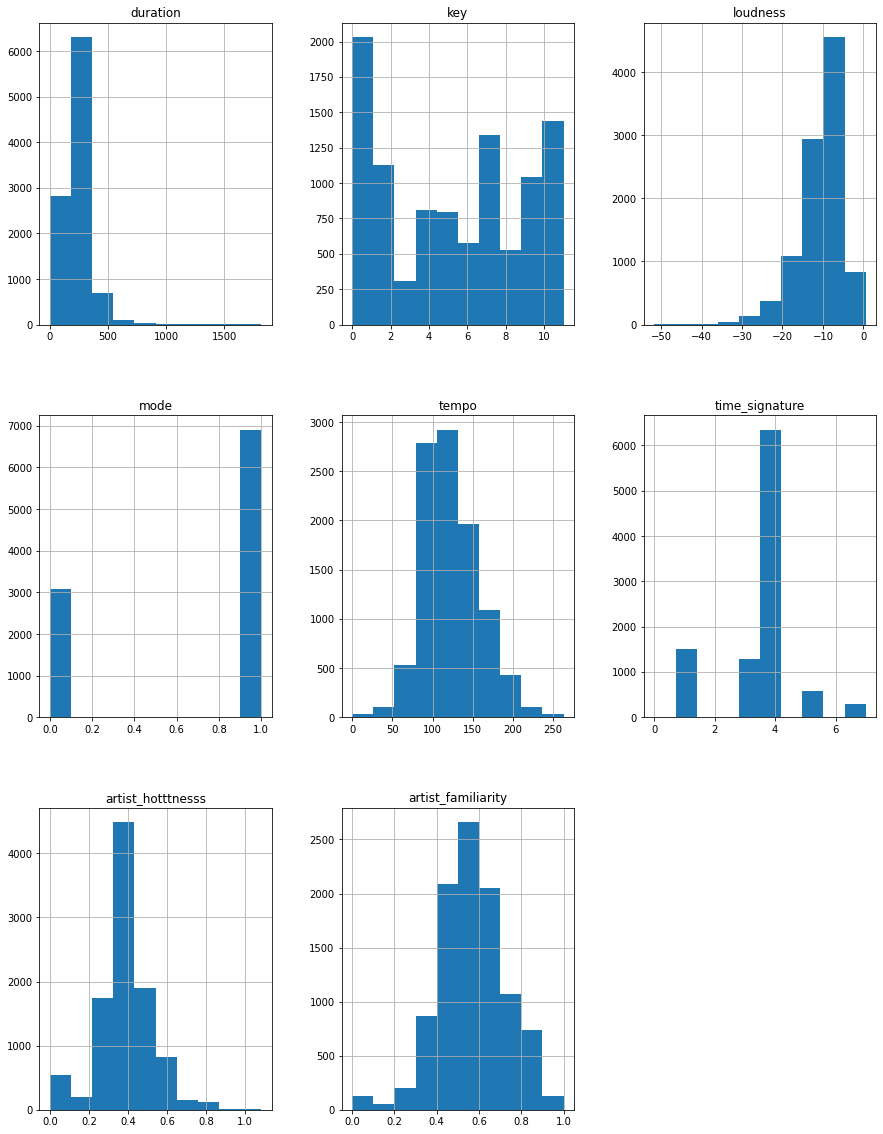

In [25]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data_MSD.toPandas().hist(ax = ax)

#### Now we can decide whether to apply normalization, standardization or both to the data.  
standardization: Dealing with outliers by using IQR method

normalization: Scale data between 0-1
- <b>duration</b>: Obviously we need both here because data is more concentrated between 0 and 500 and we have some outliers above 500 which can be addressed by standardization. 
    To scale the data between 0-1, normalization can be applied. 
- <b>key</b>: it is evenly distributed from 0 to 11 and we only apply normalization here to scale it between 0-1
- <b>loudness</b>: Same as the duration feature, we have some outliers from -50 to -30 which can be solved by standardization. Normalization will be applied too. 
- <b>mode</b>: Since this value is either 0 or 1, neither normalization is needed nor standardization 
- <b>tempo</b>: Since data is symmetrically distributed here we can overlook standardization. However, we apply it on the data to get rid of outliers on its head and tail. 
- <b>time_signature</b>: Just normalization 
- <b>artist_hottness</b>: Because data distribution is not sparse, no standardization,but normalization to make sure data is between 0-1
- <b>artist_familiarity</b>: the same as artist_hottness
    

### 1.3.3 Standardization & Normalization : 
##### - Standardardizer method: 

In [30]:
# standardize a column with IQR method
def standardize(df, column : str, lower, upper): 
    
    split_udf = udf(lambda x: float(list(x)[0].item()), DoubleType())
    
    # create a vector assembler
    assembler = VectorAssembler(inputCols=[column], outputCol='temp')
    
    # assembel the vector to dataframe 
    df = assembler.transform(df) # add temp column 
    
    scaler = RobustScaler(inputCol = 'temp',outputCol='stndr',withScaling= True, withCentering=False,lower=lower, upper=upper)
    
    # Compute summary statistics by fitting the RobustScaler
    scalerModel = scaler.fit(df) 
    
    # Transform each column to have unit quantile range.    
    df = scalerModel.transform(df)
    
    # drop the created columns and substitute with the old column
    df = df.drop(column,'temp')
    df = df.withColumn('stndr',split_udf(col('stndr')))
    df = df.withColumnRenamed('stndr', column)
    return df , scalerModel
    

#### - Normalizer method: 

In [31]:
def normalizer(df , column): 
    # UDF for converting column type from vector to double type
    split_udf = udf(lambda x: float(list(x)[0].item()), DoubleType())

    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[column],outputCol='temp')
    df = assembler.transform(df)
    
    # MaxMinScaler to scale between 0-1
    scaler = MinMaxScaler(inputCol='temp', outputCol='normalized')

    scalerModel = scaler.fit(df)
    df = scalerModel.transform(df)
    
    # drop the created columns and substitute with the old column
    df = df.drop(column,'temp')
    df = df.withColumn('normalized',split_udf(col('normalized')))
    df = df.withColumnRenamed('normalized', column)
    
    return df , scalerModel

##### Standardize following features:

'duration', 'key', 'loudness', 'mode', 'tempo', 'time_signature', 'artist_hotttnesss', 'artist_familiarity

In [32]:
scalers_stdr = {'duration': None, 
          'loudness': None,
          'tempo': None}

In [33]:
data_MSD_scaled = data_MSD
data_MSD_scaled , scalers_stdr['duration'] = standardize(data_MSD_scaled, 'duration', 0.05, 0.75)
print('Standardizing feature: '+ 'duration' )

data_MSD_scaled , scalers_stdr['loudness'] = standardize(data_MSD_scaled, 'loudness', 0.2, 0.90)
print('Standardizing feature: '+ 'loudness' )

data_MSD_scaled , scalers_stdr['tempo'] = standardize(data_MSD_scaled, 'tempo', 0.20, 0.85)
print('Standardizing feature: '+ 'tempo' )


Standardizing feature: duration
Standardizing feature: loudness
Standardizing feature: tempo


 #### Changes after Standardization: 

C:\Users\shbpa\AppData\Local\Temp/ipykernel_2712/3078121536.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_MSD_scaled.toPandas().hist(ax = ax)


array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'time_signature'}>],
       [<AxesSubplot:title={'center':'artist_hotttnesss'}>,
        <AxesSubplot:title={'center':'artist_familiarity'}>,
        <AxesSubplot:title={'center':'duration'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'tempo'}>, <AxesSubplot:>]],
      dtype=object)

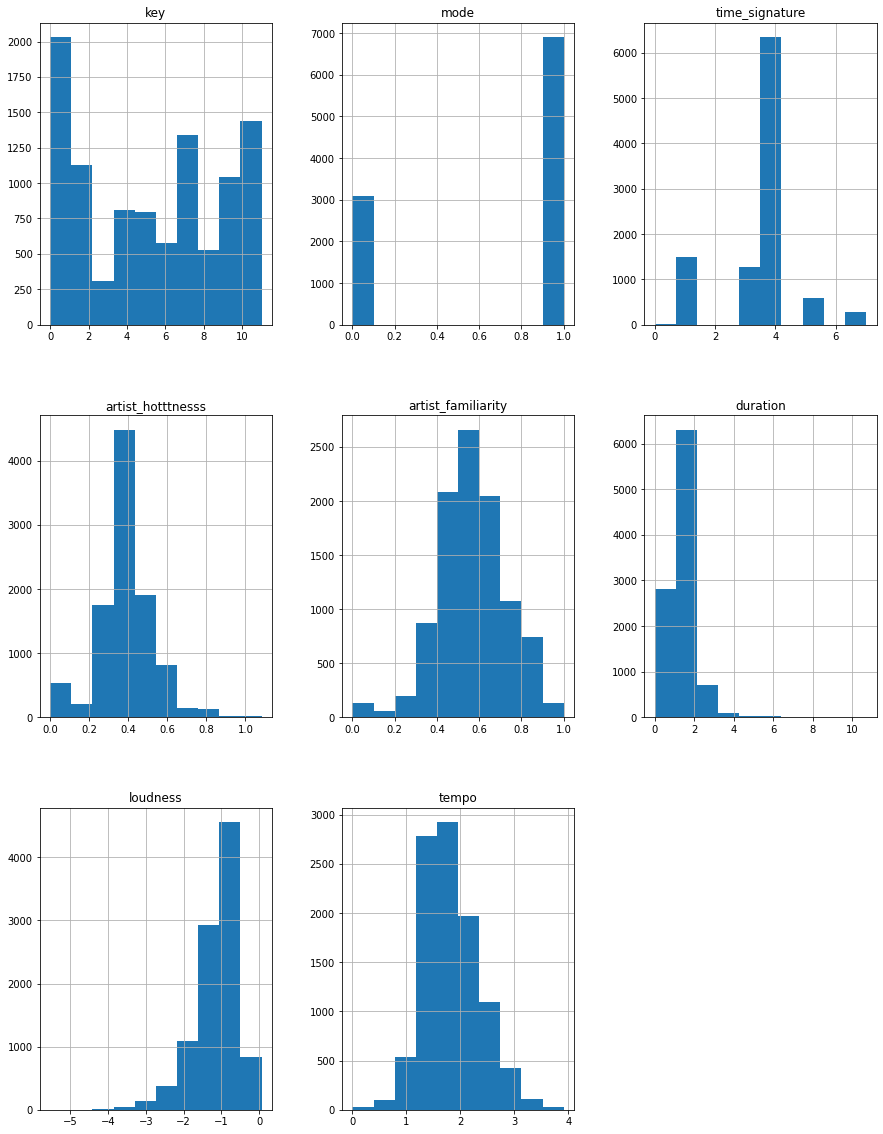

In [30]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data_MSD_scaled.toPandas().hist(ax = ax)

In [31]:
data_MSD_scaled.toPandas().describe(percentiles=[0.05,.1, .2, .5, .7, .8, .9,.95]).T

,count,mean,std,min,5%,10%,20%,50%,70%,80%,90%,95%,max
key,9996.0,5.276611,3.554199,0.000000,0.000000,0.000000,1.000000,5.000000,8.000000,9.000000,10.000000,11.000000,11.000000
mode,9996.0,0.690976,0.462114,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
time_signature,9996.0,3.564626,1.266462,0.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,4.000000,5.000000,7.000000
artist_hotttnesss,9996.0,0.385707,0.143469,0.000000,0.049034,0.257063,0.311438,0.380756,0.434411,0.476761,0.547755,0.601186,1.082503
artist_familiarity,9996.0,0.565457,0.160161,0.000000,0.321843,0.379428,0.441050,0.563666,0.637508,0.697113,0.784970,0.839275,1.000000
duration,9996.0,1.400214,0.670158,0.006131,0.620109,0.794124,0.971321,1.309459,1.543472,1.711698,2.056737,2.475576,10.682868
loudness,9996.0,-1.123764,0.578521,-5.533377,-2.242768,-1.866977,-1.527162,-1.005250,-0.756134,-0.645023,-0.524697,-0.431399,0.060645
tempo,9996.0,1.830333,0.523933,0.000000,1.103977,1.263097,1.383190,1.789388,2.055493,2.252695,2.529902,2.777229,3.913926


In [32]:
data_MSD.toPandas().describe(percentiles=[0.05,.1, .2, .5, .7, .8, .9,.95]).T

,count,mean,std,min,5%,10%,20%,50%,70%,80%,90%,95%,max
duration,9996.0,238.518509,114.157639,1.044440,105.632202,135.274643,165.459137,223.059143,262.921997,291.578308,350.353821,421.700775,1819.767700
key,9996.0,5.276611,3.554199,0.000000,0.000000,0.000000,1.000000,5.000000,8.000000,9.000000,10.000000,11.000000,11.000000
loudness,9996.0,-10.488078,5.399334,-51.643002,-20.931750,-17.424500,-14.253000,-9.382000,-7.057000,-6.020000,-4.897000,-4.026250,0.566000
mode,9996.0,0.690976,0.462114,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
tempo,9996.0,122.910576,35.183144,0.000000,74.134251,84.819500,92.884003,120.161003,138.030502,151.272995,169.888000,186.496498,262.828003
time_signature,9996.0,3.564626,1.266462,0.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,4.000000,5.000000,7.000000
artist_hotttnesss,9996.0,0.385707,0.143469,0.000000,0.049034,0.257063,0.311438,0.380756,0.434411,0.476761,0.547755,0.601186,1.082503
artist_familiarity,9996.0,0.565457,0.160161,0.000000,0.321843,0.379428,0.441050,0.563666,0.637508,0.697113,0.784970,0.839275,1.000000


#### Now its time for Normalization: 

In [34]:
scalers_norm = {'duration': None, 
          'key': None, 
          'loudness': None,
          'mode': None, 
          'tempo': None, 
          'time_signature': None, 
          'artist_hotttnesss': None,
          'artist_familiarity': None}

In [35]:
for i in scalers_norm.keys(): 
    data_MSD_scaled , scalers_norm[i] = normalizer(data_MSD_scaled, i)
    print('Normalizing feature: '+ i )

Normalizing feature: duration
Normalizing feature: key
Normalizing feature: loudness
Normalizing feature: mode
Normalizing feature: tempo
Normalizing feature: time_signature
Normalizing feature: artist_hotttnesss
Normalizing feature: artist_familiarity


#### 1.3.4 Narmalized and Standardized data:

C:\Users\shbpa\AppData\Local\Temp/ipykernel_2712/3078121536.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_MSD_scaled.toPandas().hist(ax = ax)


array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'time_signature'}>],
       [<AxesSubplot:title={'center':'artist_hotttnesss'}>,
        <AxesSubplot:title={'center':'artist_familiarity'}>,
        <AxesSubplot:>]], dtype=object)

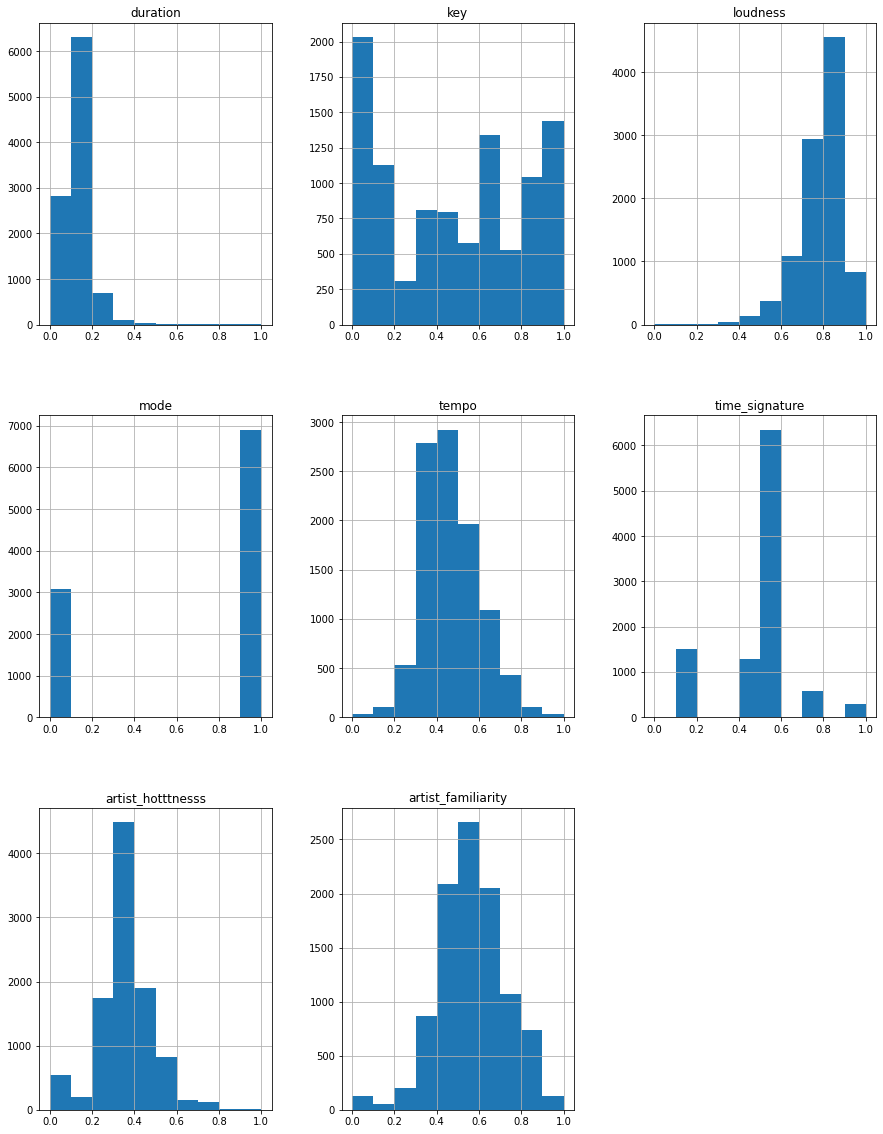

In [35]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data_MSD_scaled.toPandas().hist(ax = ax)

In [36]:
data_MSD_scaled.toPandas().describe(percentiles=[0.05,.1, .2, .5, .7, .8, .9,.95]).T

,count,mean,std,min,5%,10%,20%,50%,70%,80%,90%,95%,max
duration,9996.0,0.130572,0.062768,0.0,0.057506,0.073805,0.090401,0.122072,0.143990,0.159746,0.192063,0.231292,1.0
key,9996.0,0.479692,0.323109,0.0,0.000000,0.000000,0.090909,0.454545,0.727273,0.818182,0.909091,1.000000,1.0
loudness,9996.0,0.788272,0.103418,0.0,0.588237,0.655414,0.716160,0.809458,0.853991,0.873853,0.895363,0.912041,1.0
mode,9996.0,0.690976,0.462114,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
tempo,9996.0,0.467646,0.133864,0.0,0.282064,0.322719,0.353402,0.457185,0.525174,0.575559,0.646385,0.709576,1.0
time_signature,9996.0,0.509232,0.180923,0.0,0.142857,0.142857,0.428571,0.571429,0.571429,0.571429,0.571429,0.714286,1.0
artist_hotttnesss,9996.0,0.356310,0.132534,0.0,0.045297,0.237471,0.287702,0.351737,0.401303,0.440425,0.506008,0.555367,1.0
artist_familiarity,9996.0,0.565456,0.160161,0.0,0.321843,0.379428,0.441050,0.563666,0.637508,0.697113,0.784970,0.839275,1.0


In [122]:
data_MSD_scaled.persist()

DataFrame[song_id: string, title: string, artist_id: string, duration: double, key: double, loudness: double, mode: double, tempo: double, time_signature: double, artist_hotttnesss: double, artist_familiarity: double]

#### 1.3.5 Store the scaled and pruned MSD dataset to a csv file

In [124]:
#data_MSD_scaled.write.mode("overwrite").csv('data_MSD_scaled.csv') error
data_MSD_scaled.toPandas().to_csv("data_MSD_scaled1.csv", header=True)

In [ ]:
df.write.mode(SaveMode.Overwrite).csv("file.csv")

In [ ]:
df.write.mode("overwrite").csv("file.csv")

## 2. Second dataset (User-Song implicit rating)
### 2.1 Load User-Items(Music) dataset: 
- This dataset consists of three columns: <b>userId</b>, <b>songId</b>, and number of play for each song(<b>play_count</b>). 
- Consists of 1 Million user 
- Since the Million Song Dataset is a subset of all dataset(10000 songs) we should match songs of this dataset with the songs of above dataset

In [36]:
# define schema, nullable is set true
schema2 = StructType([
    StructField('userId', StringType(), True),
    StructField('songId', StringType(), True),
    StructField('play_count', IntegerType(), True)])

In [37]:
# Read the csv file, each coloumn is divided by a tab (from csv into a spark dataframe)
data_imp_rating_full = spark.read.option("delimiter", "\t").schema(schema2).csv(data_imp_rating_path)

In [38]:
data_imp_rating_full.columns

['userId', 'songId', 'play_count']

In [57]:
data_imp_rating_full.describe().show()

+-------+--------------------+------------------+-----------------+
|summary|              userId|            songId|       play_count|
+-------+--------------------+------------------+-----------------+
|  count|            48373586|          48373586|         48373586|
|   mean|                null|              null|2.866858847305635|
| stddev|                null|              null|6.437724686877057|
|    min|00000b72200188206...|SOAAADD12AB018A9DD|                1|
|    max|fffff9534445f481b...|SOZZZWN12AF72A1E29|             9667|
+-------+--------------------+------------------+-----------------+



In [58]:
data_imp_rating_full.show(2)

+--------------------+------------------+----------+
|              userId|            songId|play_count|
+--------------------+------------------+----------+
|b80344d063b5ccb32...|SOAKIMP12A8C130995|         1|
|b80344d063b5ccb32...|SOAPDEY12A81C210A9|         1|
+--------------------+------------------+----------+
only showing top 2 rows



### 2.2 Preprocessing:  
- Since we are using a subset of songs dataset(MSD subset), it is possible that some songs in User-Songs dataset not to be in the MSD dataset. To make sure we are going to keep only songs in the MSD dataset with leftsemi join method, as follows: 

In [128]:
# whole number of user-song data
data_imp_rating_full.count()

48373586

In [39]:
# keep records with songs in the MSD data 
data_imp_rating = data_imp_rating_full.join(data_MSD, data_imp_rating_full.songId ==  data_MSD.song_id, "leftsemi")

In [130]:
data_imp_rating.persist()

DataFrame[userId: string, songId: string, play_count: int]

In [131]:
# count the number of remaining records 
data_imp_rating.count()

772661

In [65]:
data_imp_rating.describe().show()

+-------+--------------------+------------------+-----------------+
|summary|              userId|            songId|       play_count|
+-------+--------------------+------------------+-----------------+
|  count|              772661|            772661|           772661|
|   mean|                null|              null|2.684340221649598|
| stddev|                null|              null|5.454645798218129|
|    min|00001638d61892368...|SOAAAQN12AB01856D3|                1|
|    max|fffff67d54a40927c...|SOZZVMW12AB0183B52|              771|
+-------+--------------------+------------------+-----------------+



### 2.3 Splitting Data: 
Since we are going to recommend song to users based on implicit ratings, we only need to split this dataset. 
Here we are going to use two different methods of splitting data- Stratified sampling and Random split. 

Before anything, it should be mentioned that we are going to use ALS algorithm for extrapolating missing values in user-item matrix in Latent_Factor approach. This algorithm is predefined in pySpark. To use it, we should pass userId and songId as integer, while it is string in our dataset. Now, before splitting the data, two columns "songIndex" and "userIndex" should be added to the dataset. These colomns are generated simply by giving index to a column of unique songs and a column of unique users.

#### 2.3.1 Convert userIds and songIds from string to integer: 

In [40]:
# get the userId column, drop the duplicates values and put them in a window to have unique and consequtive indices
userIds= data_imp_rating.select('userId').dropDuplicates().withColumn("index",row_number().over(Window.orderBy(monotonically_increasing_id())))

In [133]:
userIds.head(5)

[Row(userId='2c218a60b3d777e9e12d56c2e065a9644b5e5f41', index=1),
 Row(userId='cc9fc2eccf0d6fe78d1fb2b0c3ff924f54482169', index=2),
 Row(userId='ae0565253d822cdc47c645a1b29cb6a5e2e2ab16', index=3),
 Row(userId='74d0c24a0bb5bde014ffbf57fc5c51b9b5b799a0', index=4),
 Row(userId='58f2d6ed090ba4626486e6ad205eb09365adfbf3', index=5)]

In [134]:
userIds.count()

418252

In [41]:
# same process as above
songIds = data_imp_rating.select('songId').dropDuplicates().withColumn("index",row_number().over(Window.orderBy(monotonically_increasing_id())))

In [136]:
songIds.count()

3675

In [137]:
songIds.head(5)

[Row(songId='SOTSIIH12A8C13A516', index=1),
 Row(songId='SOVPUVS12A6D4F7988', index=2),
 Row(songId='SOCKUUJ12A6D4FA41C', index=3),
 Row(songId='SOJUGKQ12A8C13A83A', index=4),
 Row(songId='SOSIVPO12AB017D5E9', index=5)]

##### Rename the columns and add to the data_imp_rating dataset

In [42]:
userIds = userIds.withColumnRenamed('index', 'userIndex')

In [43]:
songIds = songIds.withColumnRenamed('index', 'songIndex')

In [44]:
data_imp_rating = data_imp_rating.join(userIds, ['userId'])

In [45]:
data_imp_rating = data_imp_rating.join(songIds, ['songId'])

In [46]:
# Finall data Model of implicit rating dataset
data_imp_rating.columns

['songId', 'userId', 'play_count', 'userIndex', 'songIndex']

#### 2.3.2 Stratified sampling: 
In order to split data based on userId, users with more than 5 songs are collected to make sure we have enough data in train and test. 

In [47]:
ss = data_imp_rating.groupby('userId').agg({'userId': 'count'}).filter(col("count(userId)")>4)
ss = data_imp_rating.join(ss, ['userId'])

In [48]:
ss.columns

['userId', 'songId', 'play_count', 'userIndex', 'songIndex', 'count(userId)']

In [49]:
fractions = ss.select("userId").distinct().withColumn('fraction', F.lit(0.2)).rdd.collectAsMap()

In [50]:
test_imp_data = ss.stat.sampleBy('userId', fractions, seed = 42).drop("count(userId)")

In [51]:
cond = [test_imp_data.userId == ss.userId, test_imp_data.songId == ss.songId]

In [52]:
train_imp_data = ss.join(test_imp_data, cond , "leftanti" )#drop("count(userId)")
# train_imp_data = train_imp_data.join(ss)

In [53]:
train_imp_data = train_imp_data.drop('count(userId)')

In [54]:
test_imp_data.columns

['userId', 'songId', 'play_count', 'userIndex', 'songIndex']

In [55]:
train_imp_data.columns

['userId', 'songId', 'play_count', 'userIndex', 'songIndex']

In [152]:
test_imp_data.head(5)

[Row(userId='0359ab58a65430dd7f652138e86663709a887829', songId='SOEKSGJ12A67AE227E', play_count=2, userIndex=1414, songIndex=3276),
 Row(userId='0486147ef9c026213cf6f77d62577a9cd71f9bd3', songId='SOTXXBT12A6D4F6B25', play_count=1, userIndex=210, songIndex=2653),
 Row(userId='0486147ef9c026213cf6f77d62577a9cd71f9bd3', songId='SOCXWEG12A6D4FBEA3', play_count=1, userIndex=210, songIndex=3640),
 Row(userId='07e62756f710c6a69bdfd5a7cb7a14bfbeb773cf', songId='SODTTUB12AB0184F48', play_count=1, userIndex=904, songIndex=2314),
 Row(userId='0af944c051730d2c2ab2ddc39d3f8f4d41fc58a1', songId='SOIGZOE12AB017F37D', play_count=7, userIndex=1595, songIndex=2555)]

In [56]:
test_imp_data.persist()

DataFrame[userId: string, songId: string, play_count: int, userIndex: int, songIndex: int]

In [57]:
train_imp_data.persist()

DataFrame[userId: string, songId: string, play_count: int, userIndex: int, songIndex: int]

#### 2.3.3 Random sampling: 
Splitting the implicit rating dataset randomly. But it causes an error in content-based method because we need for each user at least one song to be able to create the user profile. Therefore spliting randomly rase an error in creating user profile. 

In [92]:
(train_random_split, test_random_split) = data_imp_rating.randomSplit([0.8, 0.2], seed = 42)

In [155]:
train_random_split.persist()

DataFrame[songId: string, userId: string, play_count: int, userIndex: int, songIndex: int]

In [156]:
test_random_split.persist()

DataFrame[songId: string, userId: string, play_count: int, userIndex: int, songIndex: int]

#### 2.3.4 Store train and test data as csv

In [160]:
test_random_split.toPandas().to_csv("test_random.csv", header=True)

In [162]:
train_random_split.toPandas().to_csv("train_random.csv", header=True)

In [97]:
train_imp_data.toPandas().to_csv("train_stratified.csv", header=True)

In [98]:
test_imp_data.toPandas().to_csv("test_stratified.csv", header=True)

# 3. Recommendation Systems: 

## 3.1Content-Based Recommendation System: 
For content-based model we can only work with train and test data generated by stratified sampling method, because we have to make sure that is possible to create users profile. If there is no song record for a user, there is no other way to create profile for the user. 

### 3.1.2 Creating user_profile data model:

In [58]:
train_CB = train_imp_data.select('userId', 'songId', 'play_count')

In [59]:
train_CB.columns

['userId', 'songId', 'play_count']

In [60]:
data_MSD_features = ['duration',
                     'key', 
                     'loudness',
                     'mode',
                     'tempo',
                     'time_signature',
                     'artist_hotttnesss', 
                     'artist_familiarity']

In [61]:
# add features of each song based on song_id from data_MSD dataset to the implicit rating test dataset(user-song-plays)
user_profile = train_CB
user_profile = user_profile.join(data_MSD_scaled, data_MSD_scaled.song_id == user_profile.songId ).drop()

In [62]:
user_profile.columns

['userId',
 'songId',
 'play_count',
 'song_id',
 'title',
 'artist_id',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [63]:
user_profile.show(5)

+--------------------+------------------+----------+------------------+--------------------+------------------+-------------------+-------------------+------------------+----+------------------+-------------------+------------------+------------------+
|              userId|            songId|play_count|           song_id|               title|         artist_id|           duration|                key|          loudness|mode|             tempo|     time_signature| artist_hotttnesss|artist_familiarity|
+--------------------+------------------+----------+------------------+--------------------+------------------+-------------------+-------------------+------------------+----+------------------+-------------------+------------------+------------------+
|0359ab58a65430dd7...|SORJVDO12AF72A1970|         7|SORJVDO12AF72A1970|  Stockholm Syndrome|ARR3ONV1187B9A2F59|0.16270486591302885|0.18181818181818182|0.8961864828611346| 0.0|0.4875203603012791| 0.5714285714285714|0.6932330032189183|0.929030

In [64]:
# calculate the product of each feature with play_count column  
for x in data_MSD_features:
    user_profile = user_profile.withColumn(x, col(x)*col('play_count'))
    
user_profile = user_profile.groupby('userId').sum('duration',
                                                  'key', 
                                                  'loudness',
                                                  'mode',
                                                  'tempo',
                                                  'time_signature',
                                                  'artist_hotttnesss', 
                                                  'artist_familiarity')


In [65]:
user_profile.columns

['userId',
 'sum(duration)',
 'sum(key)',
 'sum(loudness)',
 'sum(mode)',
 'sum(tempo)',
 'sum(time_signature)',
 'sum(artist_hotttnesss)',
 'sum(artist_familiarity)']

In [66]:
temp_name = ['sum(duration)',
             'sum(key)', 
             'sum(loudness)',
             'sum(mode)',
             'sum(tempo)',
             'sum(time_signature)',
             'sum(artist_hotttnesss)', 
             'sum(artist_familiarity)']

In [67]:
#changing the columns name same as songs dataset columns 
for x,y in zip(data_MSD_features,temp_name):
    user_profile = user_profile.withColumnRenamed(y,x)

In [68]:
user_profile.columns

['userId',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [69]:
# add a column to store the sum of feature for each user 
user_profile= user_profile.withColumn('sum', sum(user_profile[col] for col in data_MSD_features ))

# calculate the user interest probability to each feature (feature_value / sum of the value of all features) 
for x in data_MSD_features:
    user_profile= user_profile.withColumn(x, col(x)/col('sum'))

In [70]:
user_profile.columns

['userId',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity',
 'sum']

In [71]:
user_profile = user_profile.drop('sum')

In [72]:
user_profile.columns

['userId',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [73]:
user_profile.persist()

DataFrame[userId: string, duration: double, key: double, loudness: double, mode: double, tempo: double, time_signature: double, artist_hotttnesss: double, artist_familiarity: double]

#### Store user profile data model as CSV: 

In [178]:
user_profile.toPandas().to_csv("user_profile.csv", header=True)

The user profile is created based on songs he/she played!! 

<b>Now everything is ready to evaluate most similar songs for each user by Cosine distances(Cosine similarity) </b>

### 3.1.3 Cosine Similarity:  

In [179]:
# put all features into a dense vector for both songs and user profiles

assembler1 = VectorAssembler(inputCols=['duration', 'key', 'loudness',
                                        'mode', 'tempo', 'time_signature',
                                        'artist_hotttnesss', 'artist_familiarity'],outputCol='Ufeatures')

assembler2 = VectorAssembler(inputCols=['duration', 'key', 'loudness',
                                        'mode', 'tempo', 'time_signature',
                                        'artist_hotttnesss', 'artist_familiarity'],outputCol='Sfeatures')


In [180]:
df1 = assembler1.transform(user_profile).select('userId', 'Ufeatures')

In [181]:
df2 = assembler2.transform(data_MSD_scaled).select('song_id', 'Sfeatures')

In [182]:
# Join df1 and df2 dataframe in order to compare each user profile with each song
# So for each userId we have all songs  
df = df1.crossJoin(df2)

In [183]:
df.columns

['userId', 'Ufeatures', 'song_id', 'Sfeatures']

In [185]:
# create a new train df and change the name of userId column to 'ui' to be able to 
train = train_imp_data.select('userId','songId').withColumnRenamed('userId','ui')

In [186]:
#defining a multiple condition for join
cond=[df.userId == train.ui, df.song_id == train.songId]

In [188]:
result = df.join(train,cond ,'leftanti')

In [189]:
# Get cosine similarity
result = result.rdd.map(lambda x: (x['userId'], x['song_id'],
                               float(cosine_similarity([x['Ufeatures']],
                                                       [x['Sfeatures']])[0,0]))).toDF(schema=['userId', 'song_id', 'cosine_similarity'])


In [190]:
#sorting the result by cosine_similarity per each user
window = Window.partitionBy(result['userId']).orderBy(result['cosine_similarity'].desc())

In [191]:
#selecting n most relevent songs for each user
n = 10
predict_top_nSong = result.select('*', rank().over(window).alias('rank')).filter(col('rank') <= n)


In [192]:
predict_top_nSong.persist()

DataFrame[userId: string, song_id: string, cosine_similarity: double, rank: int]

In [193]:
predict_top_nSong.show()

+--------------------+------------------+------------------+----+
|              userId|           song_id| cosine_similarity|rank|
+--------------------+------------------+------------------+----+
|0359ab58a65430dd7...|SOIEAJT12A8AE458EC|0.9782267126569764|   1|
|0359ab58a65430dd7...|SODHTCY12A58A7F125|0.9775481960502393|   2|
|0359ab58a65430dd7...|SOAOPVN12AAF3B1856|0.9757378255362639|   3|
|0359ab58a65430dd7...|SOHKNRJ12A6701D1F8|0.9754747604252393|   4|
|0359ab58a65430dd7...|SOPPCXM12A6D4F66BC|0.9753965499397119|   5|
|0359ab58a65430dd7...|SOJBYGW12A8C13A497|0.9753614136521936|   6|
|0359ab58a65430dd7...|SOYEDIE12A8C142C36|0.9750551760414174|   7|
|0359ab58a65430dd7...|SOULIKU12A58A78CE2|  0.97487902678679|   8|
|0359ab58a65430dd7...|SOKZCJC12AF72A8C79|0.9747497714968003|   9|
|0359ab58a65430dd7...|SOHKXAC12A58A7F6E5|0.9738602569837279|  10|
|0486147ef9c026213...|SODMJKG12A670202EB|   0.9721507471084|   1|
|0486147ef9c026213...|SOJMQQX12AB0185046|0.9715028110137298|   2|
|0486147ef

In [212]:
predict_top_nSong.describe().show()

+-------+--------------------+------------------+--------------------+-----------------+
|summary|              userId|           song_id|   cosine_similarity|             rank|
+-------+--------------------+------------------+--------------------+-----------------+
|  count|              228361|            228361|              228361|           228361|
|   mean|                null|              null|  0.9879646869997364|5.499967157264156|
| stddev|                null|              null|0.010100157605710699|2.872313529858836|
|    min|0000f88f8d76a238c...|SOAAAQN12AB01856D3|   0.954820505706391|                1|
|    max|ffff6f29052de81f5...|SOZZWWW12A58A8146A|  0.9999345849584005|               10|
+-------+--------------------+------------------+--------------------+-----------------+



### Store predict_top_nSong data model as CSV

In [217]:
predict_top_nSong.toPandas().to_csv("CB_10Songs.csv", header=True)


In [213]:
user_profile.count()

22836

In [211]:
test_imp_data.count()

30607

In [209]:
predict_top_nSong.count()

228361

### Calculating F1: 

For each user we have n songs recommended. For F1 score we have: 

- <b>Precision</b> =  items in common with test and @ n songs recommended(TP) / number of songs in recommendder

- <b>Recall</b> =  items in common with test and @ n songs recommended(TP) / number of songs in test 

- <b>F1</b> = 2*(Precision*Recall)/(Precision+Recall) 

In [219]:
conditions = [ test_imp_data.userId == predict_top_nSong.userId , test_imp_data.songId == predict_top_nSong.song_id ]
TP = test_imp_data
TP = TP.join(predict_top_nSong , conditions, "leftsemi").count()

In [220]:
nom_of_song_test = test_imp_data.count()
nom_of_song_predicted = predict_top_nSong.count()
precision = (TP / nom_of_song_predicted)
recall = (TP / nom_of_song_test)
F1 = 2 * (precision * recall)/(precision + recall)

In [222]:
print('Precision: ', precision)
print('recall: ', recall)
print('F1: ', F1)

Precision:  0.001703443232425852
recall:  0.012709510896200215
F1:  0.003004232183126873


#### Calculating RMSE: 

In [223]:
#### Calculating RMSE: 

temp = result 
conditions = [temp.userId == test_imp_data.userId , temp.song_id == test_imp_data.songId]
pred_cosine_test = temp.join(test_imp_data, conditions, "leftsemi")
pred_cosine_test = pred_cosine_test.select('userId', 'songId', 'play_count')

df = pred_cosine_test
N = df.count() 
rmse = math.sqrt(df.withColumn("sqrderr", pow(1-df.col("cosine_similarity"), 2)).select(mean("sqrderr"))).collect()

print("RMSE = ", str(rmse/N))#### Calculating RMSE: 

#### Calculating RMSE: 

temp = result 
conditions = [temp.userId == test_imp_data.userId , temp.song_id == test_imp_data.songId]
pred_cosine_test = temp.join(test_imp_data, conditions, "leftsemi")
pred_cosine_test = pred_cosine_test.select('userId', 'songId', 'play_count')

df = pred_cosine_test
N = df.count() 
rmse = math.sqrt(df.withColumn("sqrderr", pow(1-df.col("cosine_similarity"), 2)).select(mean("sqrderr"))).collect()

print("RMSE = ", str(rmse/N))_cosine_test = pred_cosine_test.select('userId', 'songId', 'play_count')

df = pred_cosine_test
N = df.count() 
rmse = math.sqrt(df.withColumn("sqrderr", pow(1-df.col("cosine_similarity"), 2)).select(mean("sqrderr"))).collect()

print("RMSE = ", str(rmse/N))_cosine_test = pred_cosine_test.select('userId', 'songId', 'play_count')

In [224]:
df = pred_cosine_test
N = df.count() 
rmse = math.sqrt(df.withColumn("sqrderr", pow(1-df.col("cosine_similarity"), 2)).select(mean("sqrderr"))).collect()

In [226]:
print("RMSE = ", str(rmse/N))

RMSE =  0.8958034432324259


## version 2

### 3.1.2 Creating user_profile data model:

In [96]:
train_CB = train_imp_data.select('userId', 'songId', 'play_count')
train_CB2=train_CB
test_CB2 = test_imp_data

In [97]:
train_CB2.columns

['userId', 'songId', 'play_count']

In [98]:
# add labels based on average 
# calculate average number of playes for each user 
play_avg = train_CB2.groupby('userId').avg('play_count')

In [99]:
temp = train_CB2
user_song_average_train = temp.join(play_avg,'userId')

In [100]:
user_song_average_train = user_song_average_train.withColumn("label", F.when(F.col("play_count") >= F.col("avg(play_count)"),1).otherwise(0))

In [101]:
temp = test_CB2.select('userId', 'songId', 'play_count')
user_song_average_test = temp.join(play_avg,'userId')

In [102]:
user_song_average_test = user_song_average_test.withColumn("label", F.when(F.col("play_count") >= F.col("avg(play_count)"),1).otherwise(0))

In [103]:
user_song_average_train.columns

['userId', 'songId', 'play_count', 'avg(play_count)', 'label']

In [104]:
user_song_average_test.columns

['userId', 'songId', 'play_count', 'avg(play_count)', 'label']

In [78]:
user_song_average_train.show(15)

+--------------------+------------------+----------+------------------+-----+
|              userId|            songId|play_count|   avg(play_count)|label|
+--------------------+------------------+----------+------------------+-----+
|0359ab58a65430dd7...|SORJVDO12AF72A1970|         7|3.2857142857142856|    1|
|0359ab58a65430dd7...|SOIZLKI12A6D4F7B61|         5|3.2857142857142856|    1|
|0359ab58a65430dd7...|SOJCBAM12A6701FD04|         1|3.2857142857142856|    0|
|0359ab58a65430dd7...|SOTEFFR12A8C144765|         6|3.2857142857142856|    1|
|0359ab58a65430dd7...|SOPFURM12A67020D2A|         1|3.2857142857142856|    0|
|0359ab58a65430dd7...|SONRIJJ12A6701FD0A|         1|3.2857142857142856|    0|
|0359ab58a65430dd7...|SOWEUOO12A6D4F6D0C|         2|3.2857142857142856|    0|
|0486147ef9c026213...|SOBJCMO12A6D4F756F|         1|1.6666666666666667|    0|
|0486147ef9c026213...|SOBMNXE12A8C140F8A|         1|1.6666666666666667|    0|
|0486147ef9c026213...|SOPGSBP12A6701F741|         1|1.6666666666

In [79]:
user_song_average_test.show(5)

+--------------------+------------------+----------+------------------+-----+
|              userId|            songId|play_count|   avg(play_count)|label|
+--------------------+------------------+----------+------------------+-----+
|0359ab58a65430dd7...|SOEKSGJ12A67AE227E|         2|3.2857142857142856|    0|
|0486147ef9c026213...|SOCXWEG12A6D4FBEA3|         1|1.6666666666666667|    0|
|0486147ef9c026213...|SOTXXBT12A6D4F6B25|         1|1.6666666666666667|    0|
|07e62756f710c6a69...|SODTTUB12AB0184F48|         1|17.272727272727273|    0|
|0af944c051730d2c2...|SOIGZOE12AB017F37D|         7|1.8333333333333333|    1|
+--------------------+------------------+----------+------------------+-----+
only showing top 5 rows



In [105]:
data_MSD_features = ['duration',
                     'key', 
                     'loudness',
                     'mode',
                     'tempo',
                     'time_signature',
                     'artist_hotttnesss', 
                     'artist_familiarity']

In [106]:
user_profile2 = user_song_average_train.filter(col('label')== 1)

In [107]:
user_profile2.show(5)

+--------------------+------------------+----------+------------------+-----+
|              userId|            songId|play_count|   avg(play_count)|label|
+--------------------+------------------+----------+------------------+-----+
|0359ab58a65430dd7...|SORJVDO12AF72A1970|         7|3.2857142857142856|    1|
|0359ab58a65430dd7...|SOIZLKI12A6D4F7B61|         5|3.2857142857142856|    1|
|0359ab58a65430dd7...|SOTEFFR12A8C144765|         6|3.2857142857142856|    1|
|0486147ef9c026213...|SOESALW12A6D4F7BBD|         7|1.6666666666666667|    1|
|07e62756f710c6a69...|SOIZLKI12A6D4F7B61|        21|17.272727272727273|    1|
+--------------------+------------------+----------+------------------+-----+
only showing top 5 rows



In [108]:
# add features of each song based on song_id from data_MSD dataset to the implicit rating test dataset(user-song-plays)
user_profile2 = user_profile2.join(data_MSD_scaled, data_MSD_scaled.song_id == user_profile2.songId )

In [109]:
user_profile2 = user_profile2.drop('song_id','title','artist_id')

In [110]:
user_profile2.columns

['userId',
 'songId',
 'play_count',
 'avg(play_count)',
 'label',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [111]:
user_profile2.show(5)

+--------------------+------------------+----------+------------------+-----+-------------------+-------------------+------------------+----+------------------+-------------------+-------------------+------------------+
|              userId|            songId|play_count|   avg(play_count)|label|           duration|                key|          loudness|mode|             tempo|     time_signature|  artist_hotttnesss|artist_familiarity|
+--------------------+------------------+----------+------------------+-----+-------------------+-------------------+------------------+----+------------------+-------------------+-------------------+------------------+
|0359ab58a65430dd7...|SORJVDO12AF72A1970|         7|3.2857142857142856|    1|0.16270486591302885|0.18181818181818182|0.8961864828611346| 0.0|0.4875203603012791| 0.5714285714285714| 0.6932330032189183|0.9290302991867065|
|0359ab58a65430dd7...|SOIZLKI12A6D4F7B61|         5|3.2857142857142856|    1| 0.1145311181553525| 0.6363636363636364|0.9

In [112]:
data_MSD_scaled.columns

['song_id',
 'title',
 'artist_id',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [113]:
# calculate the product of each feature with play_count column  
for x in data_MSD_features:
    user_profile2 = user_profile2.withColumn(x, col(x)*col('play_count'))
    
user_profile2 = user_profile2.groupby('userId').sum('duration',
                                                  'key', 
                                                  'loudness',
                                                  'mode',
                                                  'tempo',
                                                  'time_signature',
                                                  'artist_hotttnesss', 
                                                  'artist_familiarity')

In [114]:
#changing the columns name same as songs dataset columns 
for x,y in zip(data_MSD_features,temp_name):
    
    user_profile2 = user_profile2.withColumnRenamed(y,x)

In [115]:
user_profile2.columns

['userId',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [116]:
# add a column to store the sum of feature for each user 
user_profile2= user_profile2.withColumn('sum', sum(user_profile2[col] for col in data_MSD_features ))

# calculate the user interest probability to each feature (feature_value / sum of the value of all features) 
for x in data_MSD_features:
    user_profile2= user_profile2.withColumn(x, col(x)/col('sum'))

In [117]:
user_profile2.columns

['userId',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity',
 'sum']

In [118]:
user_profile2 = user_profile2.drop('sum')

In [119]:
user_profile2.columns

['userId',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity']

In [120]:
user_profile2.persist()

DataFrame[userId: string, duration: double, key: double, loudness: double, mode: double, tempo: double, time_signature: double, artist_hotttnesss: double, artist_familiarity: double]

#### Store user profile data model as CSV: 

In [98]:
user_profile2.toPandas().to_csv("user_profile2.csv", header=True)

### 3.1.3 Cosine Similarity:  

In [121]:
# put all features into a dense vector for both songs and user profiles

assembler1 = VectorAssembler(inputCols=['duration', 'key', 'loudness',
                                        'mode', 'tempo', 'time_signature',
                                        'artist_hotttnesss', 'artist_familiarity'],outputCol='Ufeatures')

assembler2 = VectorAssembler(inputCols=['duration', 'key', 'loudness',
                                        'mode', 'tempo', 'time_signature',
                                        'artist_hotttnesss', 'artist_familiarity'],outputCol='Sfeatures')


In [122]:
df1 = assembler1.transform(user_profile2).select('userId', 'Ufeatures')

In [123]:
df2 = assembler2.transform(data_MSD_scaled).select('song_id', 'Sfeatures')

In [124]:
# Join df1 and df2 dataframe in order to compare each user profile with each song
# So for each userId we have all songs  
df = df1.crossJoin(df2)

In [125]:
df.columns

['userId', 'Ufeatures', 'song_id', 'Sfeatures']

In [126]:
# create a new train df and change the name of userId column to 'ui' to be able to 
train = train_imp_data.select('userId','songId').withColumnRenamed('userId','ui')

In [127]:
#defining a multiple condition for join
cond=[df.userId == train.ui, df.song_id == train.songId]

In [128]:
result2 = df.join(train,cond ,'leftanti')

In [129]:
# Get cosine similarity
result2 = result2.rdd.map(lambda x: (x['userId'], x['song_id'],
                               float(cosine_similarity([x['Ufeatures']],
                                                       [x['Sfeatures']])[0,0]))).toDF(schema=['userId', 'song_id', 'cosine_similarity'])


In [130]:
#add 0-1 label based on cosine similarity threshold
threshold = 0.5
result2 = result2.withColumn("predicted_label", F.when(F.col("cosine_similarity") >= threshold,1).otherwise(0))

In [131]:
result2.columns

['userId', 'song_id', 'cosine_similarity', 'predicted_label']

In [139]:
result2.show(3)

+--------------------+------------------+------------------+---------------+
|              userId|           song_id| cosine_similarity|predicted_label|
+--------------------+------------------+------------------+---------------+
|0359ab58a65430dd7...|SOMZWCG12A8C13C480|0.9168492531390589|              1|
|0359ab58a65430dd7...|SOCIWDW12A8C13D406| 0.958120390066596|              1|
|0359ab58a65430dd7...|SOXVLOJ12AB0189215|0.8271429063796553|              1|
+--------------------+------------------+------------------+---------------+
only showing top 3 rows



In [132]:
#sorting the result by cosine_similarity per each user
window = Window.partitionBy(result2['userId']).orderBy(result2['cosine_similarity'].desc())

In [133]:
#selecting n most relevent songs for each user

prediction = result2.select('*', rank().over(window).alias('rank'))


In [ ]:
prediction.show(3)

In [134]:
prediction.persist()

DataFrame[userId: string, song_id: string, cosine_similarity: double, predicted_label: int, rank: int]

In [135]:
n = 10
top_recommendation_nSnog= prediction.filter(col('rank') <= n)

In [136]:
user_song_average_test.columns

['userId', 'songId', 'play_count', 'avg(play_count)', 'label']

#### Calculating RMSE: 

In [229]:
#### Calculating RMSE: 

temp = result 
conditions = [temp.userId == test_imp_data.userId , temp.song_id == test_imp_data.songId]
pred_cosine_test = temp.join(test_imp_data, conditions, "leftsemi")
pred_cosine_test = pred_cosine_test.select('userId', 'songId', 'play_count')

df = pred_cosine_test
N = df.count() 
rmse = math.sqrt(df.withColumn("sqrderr", pow(1-df.col("cosine_similarity"), 2)).select(mean("sqrderr"))).collect()

print("RMSE = ", str(rmse/N))_cosine_test = pred_cosine_test.select('userId', 'songId', 'play_count')

In [230]:
df = pred_cosine_test
N = df.count() 
rmse = math.sqrt(df.withColumn("sqrderr", pow(1-df.col("cosine_similarity"), 2)).select(mean("sqrderr"))).collect()

In [231]:
print("RMSE = ", str(0.7710012038714518))

RMSE =  0.7710012038714518


# 4. Collaborative Filtering: 

### 4.1 Latent Factor model: 
#### 4.1.1 Train and test split with stratified sampling  method: 

In [223]:
# ALS Algorithm to fill null values
# Build the recommendation model using ALS on the training data
# Rating is implicit in our model, it is biased too, so the implicitPrefs assigned true to add biased terms to the algorithm
# In this step we are not dealing with cold-start issues so the coldStartStrategy is droped

als = ALS(maxIter=10,regParam=0.01, userCol="userIndex", itemCol="songIndex", ratingCol="play_count",implicitPrefs = True,coldStartStrategy="drop")


In [224]:
model_CF = als.fit(train_imp_data)


In [225]:
predictions = model_CF.transform(test_imp_data)

In [226]:
# Evaluate the model by computing RMSE
evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="play_count",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("RMSE error = " + str(rmse))


RMSE error = 4.279752515546069


In [228]:
# Generate top 10 songs recommendations
userRecs = model_CF.recommendForAllUsers(10)

In [229]:
userRecs.show()

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|     7240|[[513, 0.876827],...|
|     7880|[[2070, 0.2594938...|
|    57370|[[1594, 1.0294975...|
|    65220|[[2130, 0.7208005...|
|    94950|[[2070, 0.5884137...|
|   111300|[[863, 0.5618871]...|
|   189310|[[1594, 0.496572]...|
|   239370|[[2070, 0.0675105...|
|   243440|[[3276, 0.8137020...|
|   279120|[[2070, 0.3801165...|
|   280340|[[649, 0.8879849]...|
|   308930|[[513, 0.68086624...|
|   310950|[[2070, 0.1632575...|
|   336620|[[2463, 0.5566273...|
|   343180|[[2068, 0.5510056...|
|   369410|[[3293, 0.4774469...|
|   376270|[[2259, 0.0376724...|
|    16861|[[1594, 0.5194273...|
|    38311|[[513, 0.24565198...|
|    49331|[[191, 0.15010667...|
+---------+--------------------+
only showing top 20 rows



In [230]:
userRecs.first()

Row(userIndex=7240, recommendations=[Row(songIndex=513, rating=0.8768270015716553), Row(songIndex=272, rating=0.5853037238121033), Row(songIndex=3056, rating=0.49465104937553406), Row(songIndex=1633, rating=0.4029790163040161), Row(songIndex=2092, rating=0.3559951186180115), Row(songIndex=2463, rating=0.2684287428855896), Row(songIndex=3169, rating=0.22356276214122772), Row(songIndex=863, rating=0.20198214054107666), Row(songIndex=2259, rating=0.2015409916639328), Row(songIndex=436, rating=0.18975648283958435)])

#### 4.1.2 Train and test split with random sampling  method: 

In [26]:
als_random = ALS(maxIter=10,regParam=0.01, 
          userCol="userIndex", 
          itemCol="songIndex", 
          ratingCol="play_count",
          implicitPrefs = True,coldStartStrategy="drop")

In [27]:
model_CF_randomSplit = als_random.fit(train_random_split)


In [28]:
predictions_random = model_CF_randomSplit.transform(test_random_split)

In [30]:
# Evaluate the model by computing RMSE
evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="play_count",
                                predictionCol="prediction")
rmse_random = evaluator.evaluate(predictions_random)
print("RMSE_random error = " + str(rmse_random))


RMSE_random error = 5.325317016701323


### 4.1.3 Run ALS for all dataset(2M) user-song

#### 4.1.3.1 Convert userIds and songIds from string to integer: 

In [10]:
# get the userId column, drop the duplicates values and put them in a window to have unique and consequtive indices
userIds= data_imp_rating_full.select('userId').dropDuplicates().withColumn("index",row_number().over(Window.orderBy(monotonically_increasing_id())))

In [11]:
userIds.head(5)

[Row(userId='b11e6a84c54160e61efdb9cb5a572b419aa33ae9', index=1),
 Row(userId='2c218a60b3d777e9e12d56c2e065a9644b5e5f41', index=2),
 Row(userId='672a1973a091e8ed8f4d46e3a740621f5fa4176c', index=3),
 Row(userId='e51bbbd28659be4018f7640978adfbd96dd2e9f8', index=4),
 Row(userId='cc9fc2eccf0d6fe78d1fb2b0c3ff924f54482169', index=5)]

In [12]:
userIds.count()

1019318

In [13]:
# same process as above
songIds = data_imp_rating_full.select('songId').dropDuplicates().withColumn("index",row_number().over(Window.orderBy(monotonically_increasing_id())))

In [136]:
songIds.count()

3675

In [137]:
songIds.head(5)

[Row(songId='SOTSIIH12A8C13A516', index=1),
 Row(songId='SOVPUVS12A6D4F7988', index=2),
 Row(songId='SOCKUUJ12A6D4FA41C', index=3),
 Row(songId='SOJUGKQ12A8C13A83A', index=4),
 Row(songId='SOSIVPO12AB017D5E9', index=5)]

##### Rename the columns and add to the data_imp_rating dataset

In [138]:
userIds = userIds.withColumnRenamed('index', 'userIndex')

In [139]:
songIds = songIds.withColumnRenamed('index', 'songIndex')

In [140]:
data_imp_rating = data_imp_rating.join(userIds, ['userId'])

In [141]:
data_imp_rating = data_imp_rating.join(songIds, ['songId'])

In [142]:
# Finall data Model of implicit rating dataset
data_imp_rating.columns

['songId', 'userId', 'play_count', 'userIndex', 'songIndex']

In [149]:
(train_random_split_F, test_random_split_F) = data_imp_rating_full.randomSplit([0.8, 0.2], seed = 42)

In [150]:
als_random_complete = ALS(maxIter=10,regParam=0.01, 
          userCol="userIndex", 
          itemCol="songIndex", 
          ratingCol="play_count",
          implicitPrefs = True,coldStartStrategy="drop")

In [151]:
model_CF_randomSplit_F = als_random_complete.fit(train_random_split_F)

In [154]:
predictions_random_F = model_CF_randomSplit_F.transform(test_random_split_F)

In [156]:
# Evaluate the model by computing RMSE
evaluator_F = RegressionEvaluator(metricName="rmse", 
                                labelCol="play_count",
                                predictionCol="prediction")
rmse_random_F = evaluator.evaluate(predictions_random_F)
print("RMSE_random error = " + str(rmse_random_F))

RMSE_random error = 4.427865231011473


## 5. KMeans Classifier for New users

In [138]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import random

In [139]:

dataset= data_MSD_scaled.select('song_id','duration', 'key', 'loudness','mode', 'tempo',
                                'time_signature','artist_hotttnesss', 'artist_familiarity')

In [140]:
assembler1 = VectorAssembler(inputCols=['duration', 'key', 'loudness',
                                        'mode', 'tempo', 'time_signature',
                                        'artist_hotttnesss', 'artist_familiarity'],outputCol='features')
df1 = assembler1.transform(dataset)

In [141]:
df1.columns

['song_id',
 'duration',
 'key',
 'loudness',
 'mode',
 'tempo',
 'time_signature',
 'artist_hotttnesss',
 'artist_familiarity',
 'features']

In [142]:
# Trains a k-means model.
kmeans = KMeans().setK(10)
model = kmeans.fit(df1.select('features'))

In [143]:
# Make predictions
predictions = model.transform(df1)

In [144]:
songs_predicted_class=predictions.select('song_id','prediction')

In [145]:
songs_predicted_class.show(10)

+------------------+----------+
|           song_id|prediction|
+------------------+----------+
|SOMZWCG12A8C13C480|         4|
|SOCIWDW12A8C13D406|         0|
|SOXVLOJ12AB0189215|         6|
|SONHOTT12A8C13493C|         3|
|SOFSOCN12A8C143F5D|         3|
|SOYMRWW12A6D4FAB14|         2|
|SOMJBYD12A6D4F8557|         9|
|SOHKNRJ12A6701D1F8|         4|
|SOIAZJW12AB01853F1|         2|
|SOUDSGM12AC9618304|         0|
+------------------+----------+
only showing top 10 rows



In [147]:
window = Window.partitionBy(songs_predicted_class['prediction']).orderBy('song_id')

In [148]:
predict_class = songs_predicted_class.select('*', rank().over(window).alias('rank'))

In [152]:
# Adding rank to based on songs class 
max_rank = predict_class.groupby('prediction').max('rank').collect()
max_rank

[Row(prediction=1, max(rank)=1386),
 Row(prediction=6, max(rank)=525),
 Row(prediction=3, max(rank)=1042),
 Row(prediction=5, max(rank)=1119),
 Row(prediction=9, max(rank)=573),
 Row(prediction=4, max(rank)=1272),
 Row(prediction=8, max(rank)=827),
 Row(prediction=7, max(rank)=334),
 Row(prediction=2, max(rank)=1435),
 Row(prediction=0, max(rank)=1483)]

In [159]:
max_rank_lst = [[a[0],random.randint(0, a[1])] for a in max_rank]
max_rank_lst

[[1, 231],
 [6, 34],
 [3, 863],
 [5, 403],
 [9, 126],
 [4, 317],
 [8, 811],
 [7, 245],
 [2, 1416],
 [0, 277]]

In [162]:
#applying the 10 random ranks on the coresponding class
rdf=[]
for a in max_rank_lst:
    rdf.append(predict_class.filter((col('prediction')==a[0])&
                                        (col('rank')== a[1])).collect())

In [163]:
rdf

[[Row(song_id='SODXECL12A8C142265', prediction=1, rank=231)],
 [Row(song_id='SOBEGZR12AB0182008', prediction=6, rank=34)],
 [Row(song_id='SOUPVPL12AB0189B9F', prediction=3, rank=863)],
 [Row(song_id='SOIZRPR12AB0180BF1', prediction=5, rank=403)],
 [Row(song_id='SOFKARX12A8AE485EE', prediction=9, rank=126)],
 [Row(song_id='SOFUPPL12A8C143A06', prediction=4, rank=317)],
 [Row(song_id='SOZMVGJ12A8AE4565D', prediction=8, rank=811)],
 [Row(song_id='SORZRPC12A8C13A1B1', prediction=7, rank=245)],
 [Row(song_id='SOZOGUO12A8C13BD9E', prediction=2, rank=1416)],
 [Row(song_id='SOENDEG12AB01887F5', prediction=0, rank=277)]]